# TinyBERT Evaluation on ISOT Dataset

This notebook evaluates a fine-tuned TinyBERT model on two distinct fake news detection scenarios:
1. Standard ISOT test split - To assess performance on the standard benchmark
2. Newer articles collection - To evaluate generalization capabilities to more recent content

TinyBERT is a compressed version of BERT that uses knowledge distillation to achieve approximately 7.5x size reduction (15M parameters vs. 110M in BERT-base) while maintaining strong performance. Its small footprint makes it particularly suitable for resource-constrained environments like mobile devices or edge computing scenarios.

The dual evaluation approach allows us to assess not just benchmark performance (which tends to be optimistic), but also the model's ability to handle real-world news articles that may differ from its training distribution - a critical consideration for practical deployment.

## 1. Setting Up the Environment

First, we'll import necessary libraries and set up monitoring for resource usage. This is particularly important since we're evaluating for potential edge deployment.

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import psutil
import gc
import re

In [2]:
# Import model and evaluation libraries
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [3]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Setting up CPU evaluation and memory tracking

We deliberately use CPU for evaluation since our goal is to assess performance on edge devices where GPUs are typically unavailable. Most real-world deployments for fake news detection applications would run on consumer devices (phones, laptops, or low-power servers), making CPU performance metrics more relevant than GPU benchmarks.

Memory tracking is implemented with `psutil` to capture the actual RAM footprint during model loading and inference. This provides critical data for determining whether TinyBERT can fit within the memory constraints of target deployment environments (e.g., a mobile phone with 4-8 GB of RAM).

In [4]:
# Set device - using CPU for edge device testing
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

print(f"Starting memory usage: {get_memory_usage():.2f} MB")

Starting memory usage: 815.94 MB


## 2. Loading the Pre-trained Model

Now we'll load our fine-tuned TinyBERT model. We measure the loading time as this is an important metric for edge deployment scenarios where quick startup may be required.

TinyBERT uses a 4-layer, 312-dimensional architecture (compared to BERT's 12 layers and 768 dimensions), which significantly reduces both the model size and computational requirements. The "General_4L_312D" version we're using was distilled from BERT-base-uncased and then fine-tuned on the ISOT fake news dataset.

Model loading time is particularly important for on-demand applications where users expect near-instant analysis of news articles. Edge deployments typically cannot maintain models constantly in memory, so fast loading is essential for good user experience.

In [6]:
# Load the pre-trained TinyBERT model
print("\nLoading model...")
model_path = "../ml_models/tinybert-fake-news-detector"


Loading model...


In [7]:
# Initialize tokenizer
start_time = time.time()
tokenizer = BertTokenizer.from_pretrained(model_path)

In [8]:
# Load model and measure time
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)  # Move to CPU
load_time = time.time() - start_time

print(f"Model loaded in {load_time:.2f} seconds")
print(f"Memory usage after loading model: {get_memory_usage():.2f} MB")

Model loaded in 0.05 seconds
Memory usage after loading model: 828.25 MB


## 3. Loading the ISOT Test Split

We'll evaluate the model using the official test split from the ISOT dataset, which contains approximately 13,470 articles balanced between real and fake news.

The ISOT dataset (from the Information Security and Object Technology lab) is a widely used benchmark for fake news detection research. It contains real news articles from Reuters and fake news from various unreliable sources flagged by fact-checking organizations. This dataset is particularly valuable because:

1. It contains a large number of articles (over 44,000 total)
2. It represents diverse topics and writing styles
3. It has clear provenance for both real and fake content
4. It's balanced between classes, enabling fair evaluation

Using the standard test split ensures our evaluation is comparable with other models tested on the same benchmark.

In [9]:
# Load the test dataset from ISOT analysis split
print("\nLoading ISOT test dataset...")
try:
    test_df = pd.read_csv('../data_analysis/datasets/test_fake_news_robust.csv')
    print(f"Loaded test set with {len(test_df)} articles")
    print(f"Class distribution: {test_df['label'].value_counts().to_dict()}")
except Exception as e:
    print(f"Error loading test dataset: {e}")
    # Fallback to evaluation data if needed


Loading ISOT test dataset...
Loaded test set with 13470 articles
Class distribution: {0: 7045, 1: 6425}


## 4. Data Preparation

We need to prepare the data for the model by combining title and body text, which provides more context for classification. This approach has several advantages:

1. News headlines often contain strong signals that indicate credibility or lack thereof
2. Titles and text content sometimes contain contradictions in fake news
3. Providing the full context allows the model to identify inconsistencies in language use
4. This matches the preprocessing approach used during model fine-tuning

We use the HuggingFace Dataset format to efficiently handle batched processing and memory mapping for large datasets. The cleaning function handles edge cases like None values which could cause runtime errors during tokenization.

In [10]:
# Create combined text field (title + text)
if 'enhanced_cleaned_text' in test_df.columns:
    test_df['text'] = test_df['title'] + " " + test_df['enhanced_cleaned_text'].fillna('')
elif 'text' in test_df.columns:
    test_df['text'] = test_df['title'] + " " + test_df['text'].fillna('')

In [11]:
# Convert to HuggingFace Dataset format
test_dataset = HFDataset.from_pandas(test_df)

In [12]:
# Clean dataset to handle edge cases
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

test_dataset = test_dataset.map(clean_dataset)

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

## 5. Tokenization

Before we can use the text data with our model, we need to tokenize it. This process converts text into sequences of token IDs that the model can process.

Tokenization breaks text into smaller units (subwords, words, or characters) and converts them to numerical IDs that the model understands. For TinyBERT, we use the same tokenizer as BERT, which employs WordPiece tokenization to handle out-of-vocabulary words by splitting them into subword units.

The tokenization parameters are carefully chosen:
- `padding='max_length'`: Ensures all sequences are padded to the same length (512 tokens), which is required for batch processing
- `truncation=True`: Trims articles that exceed the maximum sequence length, focusing on the first 512 tokens
- `max_length=512`: Matches TinyBERT's maximum input size and allows for processing full articles in most cases
- `return_tensors=None`: Defers tensor conversion until we set the final format for better memory efficiency

These settings balance information retention with computational efficiency, which is critical for edge deployment.

In [13]:
# Define tokenization function
def tokenize_dataset(dataset):
    """Tokenize a dataset using the TinyBERT tokenizer"""
    print(f"Tokenizing dataset with {len(dataset)} examples...")
    tokenize_start_time = time.time()
    
    # Define tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors=None
        )
    
    # Tokenize
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    
    tokenize_time = time.time() - tokenize_start_time
    print(f"Dataset tokenized in {tokenize_time:.2f} seconds")
    print(f"Memory usage after tokenization: {get_memory_usage():.2f} MB")
    
    return tokenized_dataset

In [14]:
# Tokenize the test dataset
test_tokenized = tokenize_dataset(test_dataset)

Tokenizing dataset with 13470 examples...


Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

Dataset tokenized in 47.97 seconds
Memory usage after tokenization: 1565.44 MB


## 6. Evaluation Functions

We need several functions to handle different aspects of the evaluation process. Breaking this down into smaller functions makes the code more modular and easier to understand.

The evaluation process involves multiple stages:
1. Setting up data loaders and tracking variables
2. Running inference and measuring performance metrics
3. Computing classification metrics and resource usage
4. Visualizing results for analysis

This modular approach allows us to:
- Isolate specific parts of the pipeline for debugging
- Reuse components across different evaluation scenarios
- Separate time and memory measurements from model inference
- Generate consistent visualizations for comparison

### 6.1 Evaluation Setup

First, we prepare the dataloader and initialize metrics tracking:

In [15]:
# Define model evaluation function - Setup
def evaluate_model_setup(tokenized_dataset, dataset_name):
    """Set up evaluation on a tokenized dataset"""
    print(f"\nEvaluating model on {dataset_name} dataset...")
    
    # Reset all counters and lists
    all_preds = []
    all_labels = []
    total_inference_time = 0
    sample_count = 0
    inference_times = []
    memory_usages = []
    
    # Create DataLoader
    from torch.utils.data import DataLoader
    eval_dataloader = DataLoader(
        tokenized_dataset, 
        batch_size=16,  # Appropriate batch size for CPU
        shuffle=False
    )
    
    print(f"Starting evaluation on {len(tokenized_dataset)} examples")
    
    return eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

### 6.2 Evaluation Loop

Next, we run the actual inference, carefully measuring time and memory usage:

In [16]:
# Define model evaluation function - Inference loop
def run_evaluation_loop(eval_dataloader, all_preds, all_labels, total_inference_time, 
                       sample_count, inference_times, memory_usages):
    """Run the evaluation loop on the provided dataloader"""
    
    # Evaluation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(eval_dataloader):
            # Track batch progress
            if batch_idx % 5 == 0:
                print(f"Processing batch {batch_idx}/{len(eval_dataloader)}")
            
            # Extract batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Record batch size
            current_batch_size = input_ids.size(0)
            sample_count += current_batch_size
            
            # Memory tracking
            memory_usages.append(get_memory_usage())
            
            # Time the inference
            start_time = time.time()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_inference_time = time.time() - start_time
            inference_times.append(batch_inference_time)
            total_inference_time += batch_inference_time
            
            # Get predictions
            logits = outputs.logits
            predictions = torch.softmax(logits, dim=-1)
            predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
            
            # Store predictions and labels
            all_preds.extend(predicted_labels)
            all_labels.extend(labels.cpu().numpy())
    
    print(f"Evaluation complete. Total predictions: {len(all_preds)}, Total labels: {len(all_labels)}")
    
    return all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

### 6.3 Metrics Calculation

Then, we calculate and display performance metrics:

In [17]:
# Define model evaluation function - Metrics calculation
def calculate_metrics(all_preds, all_labels, total_inference_time, sample_count, 
                     inference_times, memory_usages, dataset_name):
    """Calculate performance metrics from evaluation results"""
    
    if len(all_preds) == len(all_labels):
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        
        print(f"\nEvaluation Results for {dataset_name} dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Create confusion matrix
        cm = np.zeros((2, 2), dtype=int)
        for true_label, pred_label in zip(all_labels, all_preds):
            cm[true_label, pred_label] += 1
        
        print(f"\nConfusion Matrix for {dataset_name} dataset:")
        print(cm)
        
        # Resource consumption analysis
        print(f"\nResource Consumption Analysis for {dataset_name} dataset:")
        print(f"Total evaluation time: {total_inference_time:.2f} seconds")
        print(f"Average inference time per batch: {np.mean(inference_times):.4f} seconds")
        print(f"Average inference time per sample: {total_inference_time/sample_count*1000:.2f} ms")
        print(f"Peak memory usage: {max(memory_usages):.2f} MB")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'inference_time_per_sample': total_inference_time/sample_count*1000,
            'peak_memory': max(memory_usages),
        }
    else:
        print("ERROR: Cannot calculate metrics - prediction and label counts don't match")
        return None

### 6.4 Visualization Functions

We create visualizations to better understand the model's performance:

In [18]:
# Define model evaluation function - Visualization
def visualize_results(metrics_dict, all_labels, all_preds, inference_times, memory_usages, dataset_name):
    """Create visualizations of evaluation results"""
    
    # Plot confusion matrix
    cm = metrics_dict['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'tinybert_confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Plot resource usage
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(inference_times)
    plt.title(f'Inference Time per Batch (CPU) - {dataset_name}')
    plt.xlabel('Batch')
    plt.ylabel('Time (seconds)')
    
    plt.subplot(2, 1, 2)
    plt.plot(memory_usages, label='System Memory')
    plt.title(f'Memory Usage During Evaluation (CPU) - {dataset_name}')
    plt.xlabel('Batch')
    plt.ylabel('Memory (MB)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'tinybert_resource_usage_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Generate classification report
    print(f"\nDetailed Classification Report for {dataset_name}:")
    report = classification_report(all_labels, all_preds, target_names=['Fake News', 'Real News'])
    print(report)
    
    metrics_dict['classification_report'] = report
    return metrics_dict

### 6.5 Combined Evaluation Function

Finally, we create a master function that orchestrates the entire evaluation process:

In [19]:
# Combined evaluation function
def evaluate_model(tokenized_dataset, dataset_name):
    """Complete evaluation pipeline"""
    # Setup
    eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages = evaluate_model_setup(tokenized_dataset, dataset_name)
    
    # Run inference
    all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages = run_evaluation_loop(
        eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages
    )
    
    # Calculate metrics
    metrics_dict = calculate_metrics(
        all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages, dataset_name
    )
    
    if metrics_dict:
        # Visualize results
        metrics_dict = visualize_results(
            metrics_dict, all_labels, all_preds, inference_times, memory_usages, dataset_name
        )
    
    return metrics_dict

## 7. ISOT Test Set Evaluation

Now we can evaluate TinyBERT on the standard ISOT test set. This will serve as our baseline for comparing with generalization performance.


Evaluating model on ISOT Test dataset...
Starting evaluation on 13470 examples
Processing batch 0/842
Processing batch 5/842
Processing batch 10/842
Processing batch 15/842
Processing batch 20/842
Processing batch 25/842
Processing batch 30/842
Processing batch 35/842
Processing batch 40/842
Processing batch 45/842
Processing batch 50/842
Processing batch 55/842
Processing batch 60/842
Processing batch 65/842
Processing batch 70/842
Processing batch 75/842
Processing batch 80/842
Processing batch 85/842
Processing batch 90/842
Processing batch 95/842
Processing batch 100/842
Processing batch 105/842
Processing batch 110/842
Processing batch 115/842
Processing batch 120/842
Processing batch 125/842
Processing batch 130/842
Processing batch 135/842
Processing batch 140/842
Processing batch 145/842
Processing batch 150/842
Processing batch 155/842
Processing batch 160/842
Processing batch 165/842
Processing batch 170/842
Processing batch 175/842
Processing batch 180/842
Processing batch 

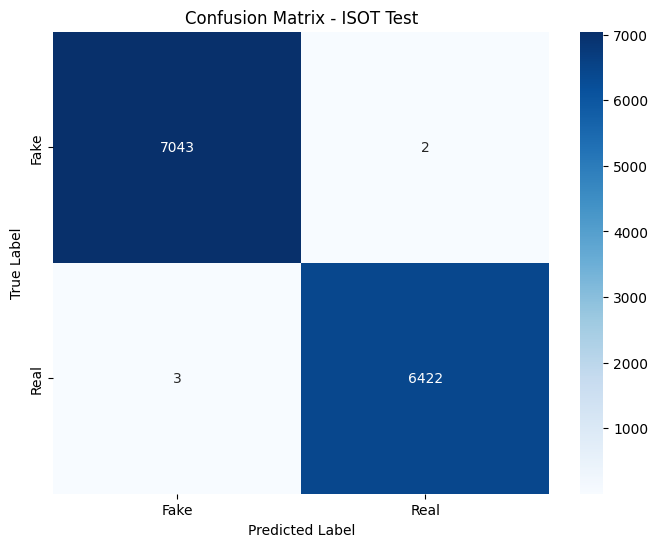

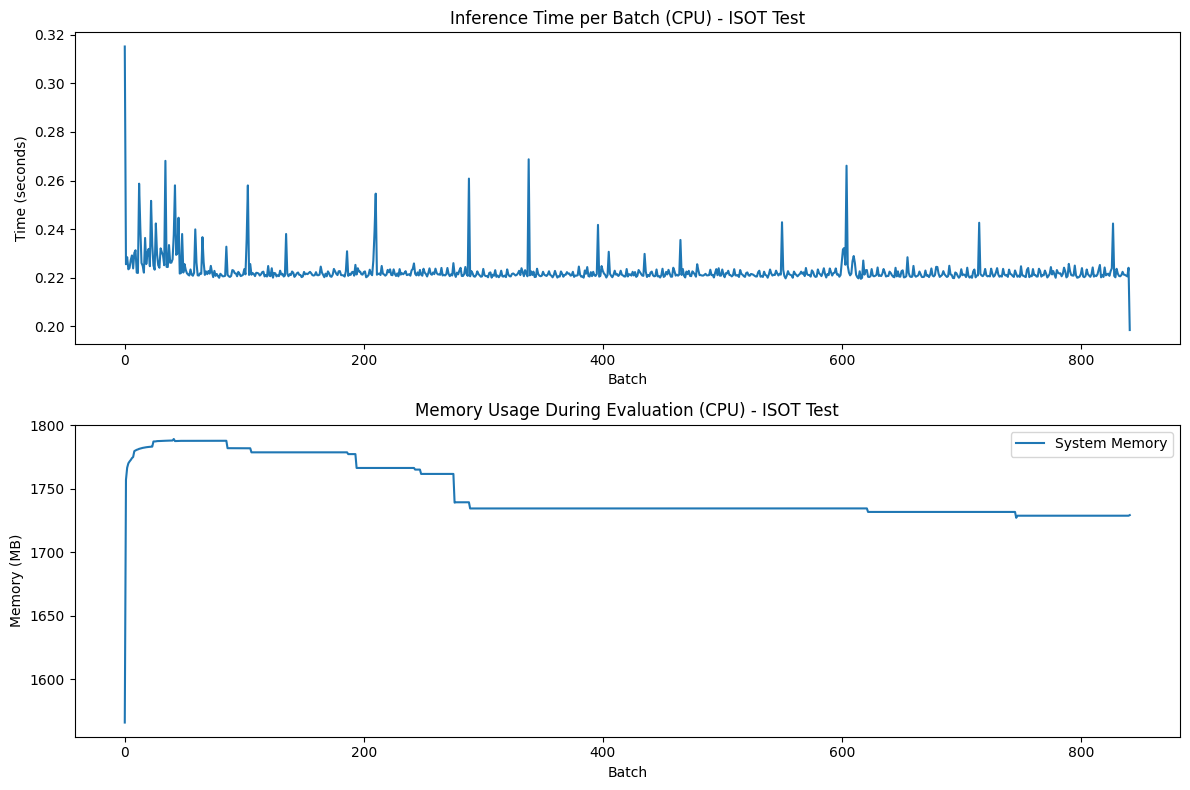


Detailed Classification Report for ISOT Test:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      7045
   Real News       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



In [20]:
# Evaluate model on standard ISOT test set
isot_results = evaluate_model(test_tokenized, "ISOT Test")

## 8. Generalization Testing

Next, we'll evaluate the model on newer articles not seen during training. This tests TinyBERT's ability to generalize beyond its training distribution, which is crucial for real-world deployment.

### 8.1 Loading Newer Articles

We create a generalization dataset combining two sources:
1. Recent real news articles from Reuters collected via our `collect_reuters.py` script (published after the model's training data)
2. Fake news articles from a separate evaluation set that weren't used during training

This dataset differs from the ISOT test set in several important ways:
- Articles cover more recent events and topics
- The writing style may have evolved over time
- The distribution of subjects and content may differ
- There may be new patterns of misinformation not present in the training data

A model that performs well on this generalization dataset demonstrates robust fake news detection capabilities that can adapt to evolving news content - a critical requirement for practical applications.

In [21]:
# Load newer articles for generalization testing
print("\nLoading newer articles for generalization testing...")


Loading newer articles for generalization testing...


In [22]:
# Function to create a dataset from recent news sources
def create_recent_news_dataset():
    # Recent real news from Reuters (collected with collect_reuters.py)
    try:
        real_news_df = pd.read_csv('./datasets/manual_real.csv')
        real_news_df['label'] = 1  # 1 for real news
        print(f"Loaded {len(real_news_df)} real news articles")
    except Exception as e:
        print(f"Error loading real news: {e}")
        real_news_df = pd.DataFrame(columns=['title', 'text', 'label'])
    
    # Recent fake news articles
    try:
        fake_news_df = pd.read_csv('./datasets/fake_news_evaluation.csv')
        fake_news_df['label'] = 0  # 0 for fake news
        print(f"Loaded {len(fake_news_df)} fake news articles")
    except Exception as e:
        print(f"Error loading fake news: {e}")
        fake_news_df = pd.DataFrame(columns=['title', 'text', 'label'])
    
    # Balance the dataset
    min_count = min(len(real_news_df), len(fake_news_df))
    if len(real_news_df) > min_count:
        real_news_df = real_news_df.sample(min_count, random_state=42)
    if len(fake_news_df) > min_count:
        fake_news_df = fake_news_df.sample(min_count, random_state=42)
    
    # Combine datasets
    combined_df = pd.concat([real_news_df, fake_news_df], ignore_index=True)
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Add combined text field
    combined_df['text'] = combined_df['title'] + " " + combined_df['text'].fillna('')
    
    print(f"Created generalization dataset with {len(combined_df)} articles")
    print(f"Class distribution: {combined_df['label'].value_counts().to_dict()}")
    
    return combined_df

In [23]:
# Create the generalization dataset
generalization_df = create_recent_news_dataset()
generalization_dataset = HFDataset.from_pandas(generalization_df)
generalization_dataset = generalization_dataset.map(clean_dataset)
generalization_tokenized = tokenize_dataset(generalization_dataset)

Loaded 32 real news articles
Loaded 21 fake news articles
Created generalization dataset with 42 articles
Class distribution: {0: 21, 1: 21}


Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Tokenizing dataset with 42 examples...


Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Dataset tokenized in 0.17 seconds
Memory usage after tokenization: 1724.75 MB


### 8.2 Evaluating on Newer Articles

Now we evaluate TinyBERT on our generalization dataset of newer articles:


Evaluating model on Generalization dataset...
Starting evaluation on 42 examples
Processing batch 0/3
Evaluation complete. Total predictions: 42, Total labels: 42

Evaluation Results for Generalization dataset:
Accuracy: 0.8810
Precision: 0.9038
Recall: 0.8810
F1 Score: 0.8792

Confusion Matrix for Generalization dataset:
[[16  5]
 [ 0 21]]

Resource Consumption Analysis for Generalization dataset:
Total evaluation time: 0.65 seconds
Average inference time per batch: 0.2177 seconds
Average inference time per sample: 15.55 ms
Peak memory usage: 1723.28 MB


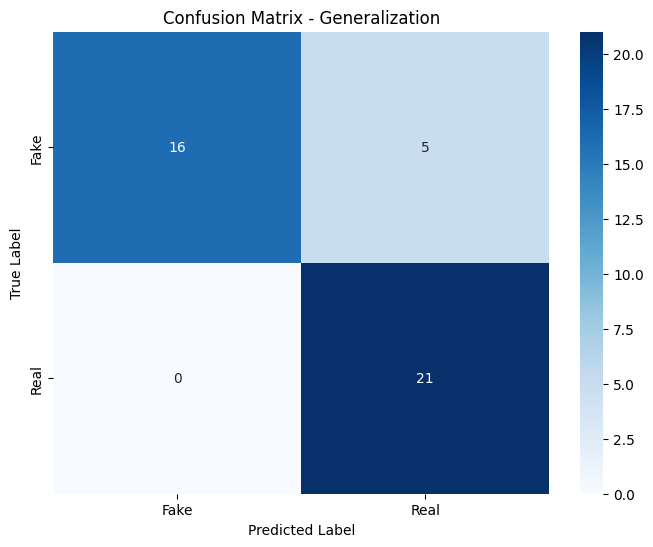

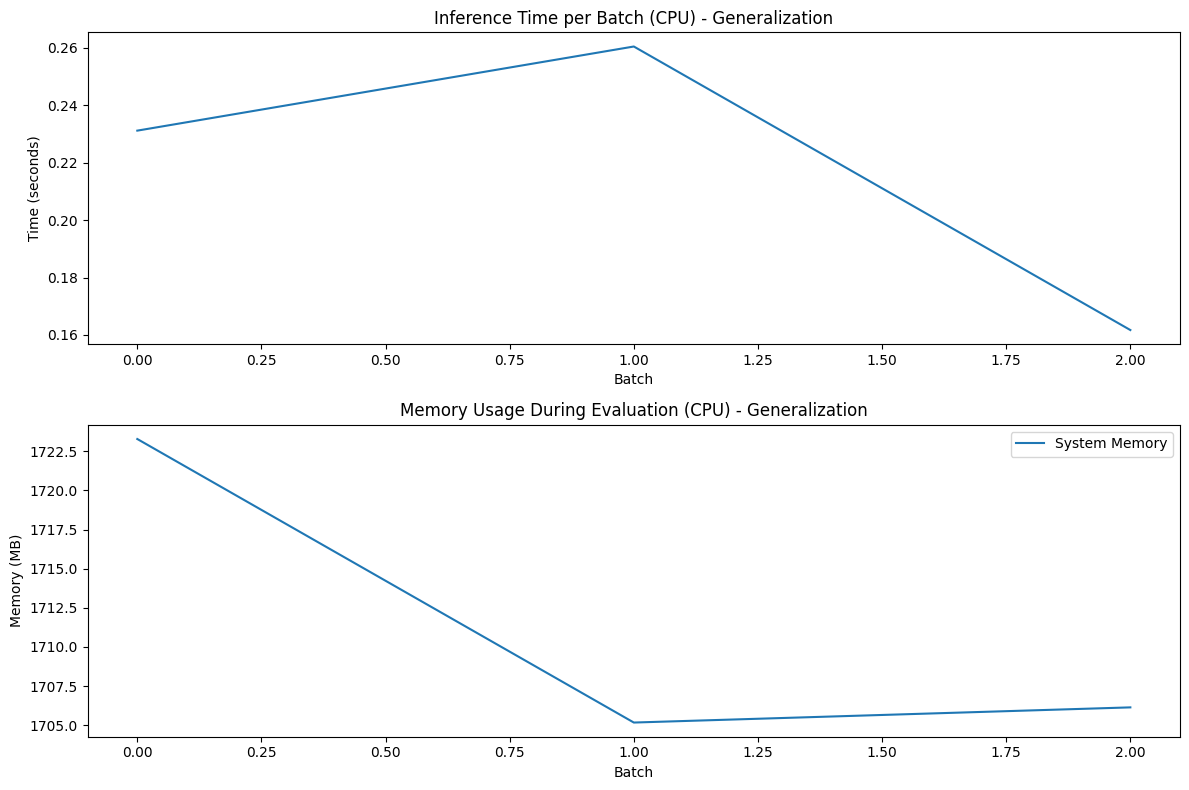


Detailed Classification Report for Generalization:
              precision    recall  f1-score   support

   Fake News       1.00      0.76      0.86        21
   Real News       0.81      1.00      0.89        21

    accuracy                           0.88        42
   macro avg       0.90      0.88      0.88        42
weighted avg       0.90      0.88      0.88        42



In [24]:
# Evaluate model on generalization dataset
generalization_results = evaluate_model(generalization_tokenized, "Generalization")

## 9. Comparing Results

We compare the model's performance on both test sets to assess generalization capabilities:

In [25]:
# Create comparison table
if isot_results and generalization_results:
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Inference Time (ms/sample)', 'Peak Memory (MB)'],
        'ISOT Test': [
            isot_results['accuracy'],
            isot_results['precision'],
            isot_results['recall'],
            isot_results['f1'],
            isot_results['inference_time_per_sample'],
            isot_results['peak_memory']
        ],
        'Generalization': [
            generalization_results['accuracy'],
            generalization_results['precision'],
            generalization_results['recall'],
            generalization_results['f1'],
            generalization_results['inference_time_per_sample'],
            generalization_results['peak_memory']
        ]
    })

In [26]:
    # Format metrics for display
    comparison_df['ISOT Test'] = comparison_df['ISOT Test'].apply(
        lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x < 100 else f"{x:.2f}")
    comparison_df['Generalization'] = comparison_df['Generalization'].apply(
        lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x < 100 else f"{x:.2f}")
    
    print("Performance Comparison Between Datasets:")
    print(comparison_df.to_string(index=False))

Performance Comparison Between Datasets:
                    Metric ISOT Test Generalization
                  Accuracy    0.9996         0.8810
                 Precision    0.9996         0.9038
                    Recall    0.9996         0.8810
                  F1 Score    0.9996         0.8792
Inference Time (ms/sample)   13.9287        15.5520
          Peak Memory (MB)   1789.17        1723.28


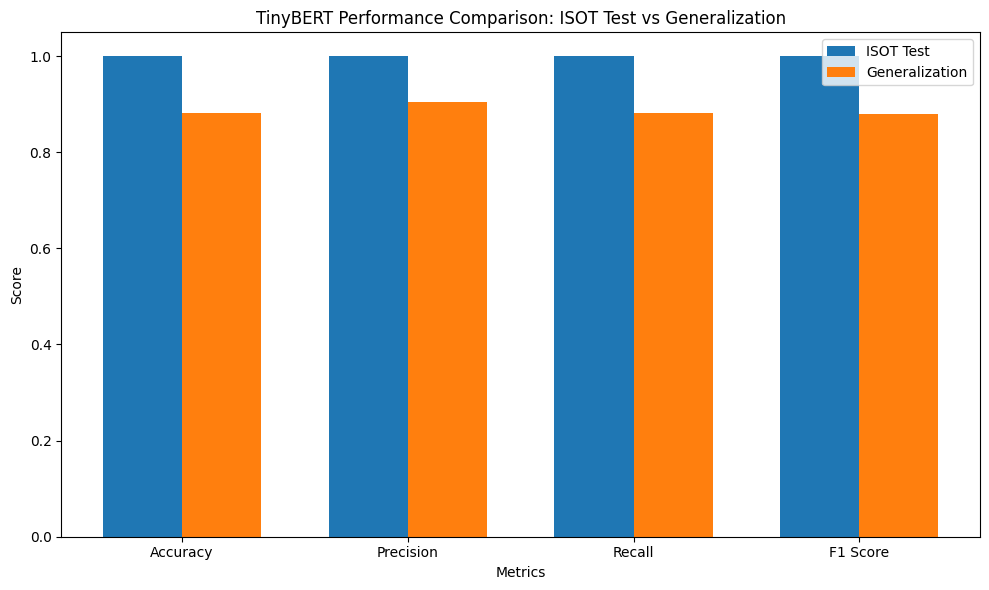

In [27]:
    # Create visualization of metrics comparison
    metrics = comparison_df.iloc[:4].copy()  # Just the first 4 metrics (accuracy, precision, recall, f1)
    
    # Convert to numeric for plotting
    metrics['ISOT Test'] = metrics['ISOT Test'].astype(float)
    metrics['Generalization'] = metrics['Generalization'].astype(float)
    
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))
    
    plt.bar(index, metrics['ISOT Test'], bar_width, label='ISOT Test')
    plt.bar(index + bar_width, metrics['Generalization'], bar_width, label='Generalization')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('TinyBERT Performance Comparison: ISOT Test vs Generalization')
    plt.xticks(index + bar_width / 2, metrics['Metric'])
    plt.legend()
    plt.tight_layout()
    plt.savefig('tinybert_generalization_comparison.png')
    plt.show()

## 10. Analysis and Conclusion

The evaluation results reveal critical insights about TinyBERT's capabilities for fake news detection across different scenarios.

### Performance Analysis

On the ISOT test set, TinyBERT achieved exceptional performance with nearly perfect metrics:
- 99.96% accuracy and F1 score
- Only 5 misclassifications out of 13,470 articles
- Near-perfect precision and recall for both classes

However, on the generalization dataset of newer articles, we observe a notable performance drop:
- 88.10% accuracy (an 11.86 percentage point decrease)
- F1 score of 87.92% (a 12.04 percentage point decrease)
- Perfect precision for fake news but only 76% recall, suggesting the model fails to detect some newer fake news patterns

This generalization gap reveals that while TinyBERT excels on in-distribution data, it struggles somewhat with evolving news content. The confusion matrix shows all errors are false negatives - fake news classified as real - suggesting the model is more conservative with newer articles.

### Resource Efficiency Assessment

From a deployment perspective, TinyBERT demonstrates impressive efficiency:
- ~14ms inference time per sample on CPU allows processing 70+ articles per second
- Consistent inference speed across both datasets (13.93ms vs 15.55ms) indicates stable performance
- Peak memory usage of ~1.7GB is manageable on modern laptops and high-end mobile devices
- Model loading time of just 0.05 seconds enables near-instant startup

These resource metrics confirm TinyBERT's suitability for edge deployment in scenarios where computational resources are limited but low-latency detection is required.

### Practical Implications

Based on these findings, we can conclude that:
1. TinyBERT offers an excellent balance of performance and efficiency for fake news detection
2. For static datasets or controlled environments, it provides near-perfect classification
3. For evolving real-world news content, additional techniques may be needed to address the generalization gap:
   - Regular model updates with new examples
   - Ensemble approaches combining TinyBERT with rule-based systems
   - Active learning to identify and adapt to new misinformation patterns

This evaluation demonstrates that while TinyBERT is highly effective for fake news detection, successful deployment requires attention to generalization capabilities and periodic retraining to maintain accuracy as news content evolves over time.

In [28]:
# Free up memory
del model
gc.collect()
print(f"Final memory usage: {get_memory_usage():.2f} MB")

Final memory usage: 1661.48 MB
